In [38]:
import scipy
import Augmentor
import numpy as np
import skimage.io as skio
import os
from data_processing import trainingset_augmentation
from model_base import Unet
from nucleus_visualize import multi_plot_image, plot_image
import data_processing.augmentation as aug
from PIL import Image
import pickle

## Read Image

In [47]:
image_stasks = skio.imread('../data/test-volume.tif')

In [48]:
print(image_stasks.shape)

(30, 512, 512)


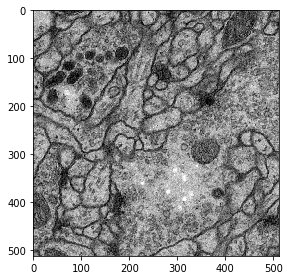

In [49]:
skio.imshow(image_stasks[1])

In [50]:
for i in range(image_stasks.shape[0]):
    skio.imsave('../data/test images/image_{}.tif'.format(i), image_stasks[i])

## data augmentation

In [3]:
trainingset_augmentation('../data/images/', 572, 572, 10000, '../data/masks')

Initialised with 30 image(s) found.
Output directory set to ../data/images/output.

30 ground truth image(s) found.


Processing <PIL.Image.Image image mode=L size=572x572 at 0x1882A31CF28>: 100%|█| 10000/10000 [06:19<00:00, 26.35 Samples/s]


In [9]:
from data_processing import get_allfile
files = get_allfile('../data/images/output')

In [51]:
trainingset_augmentation('../data/test images/', 572, 572, 1000)

Initialised with 30 image(s) found.
Output directory set to ../data/test images/output.

Processing <PIL.Image.Image image mode=L size=572x572 at 0x1883E6ED9B0>: 100%|█| 1000/1000 [00:19<00:00, 50.50 Samples/s]


## Inference

In [4]:
x, y, t = Unet.load_training_data(by_image=False, get_test=True)

Processing images_original_image_9.tif_ffe70c8d-de32-4277-a0e7-53a89b207acd.tif: 100%|█| 10000/10000 [01:22<00:00, 120.99Images/s]


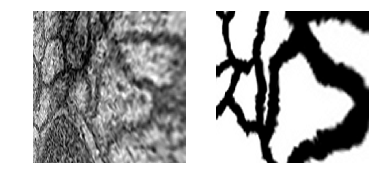

In [65]:
multi_plot_image([x[0][:,:,0], y[0][:,:,0]])

In [6]:
model = Unet()
weights_name = 'results/weights/model_unet_1126_1550_cs24.weights'
pred_y_x = model.predict(weights_name, x[0:100])
pred_y_t = model.predict(weights_name, t[0:100])

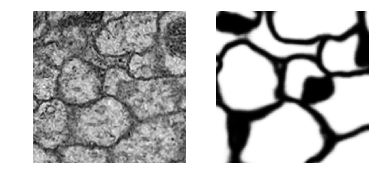

In [48]:
ind = 20
multi_plot_image([x[ind][:,:,0], pred_y_x[ind][:,:,0]])

(388, 388)


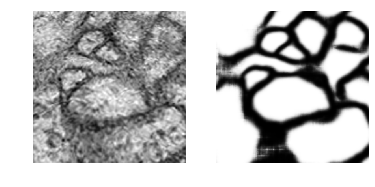

In [51]:
ind = 20
center_im = aug.crop(t[ind][:,:,0], 92, 92, 388, 388)
multi_plot_image([center_im, pred_y_t[ind][:,:,0]])

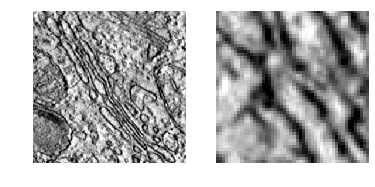

In [57]:
with Image.open('../data/golgi.tif') as im:
    im = np.array(im) / 255
golgi = aug.crop(im, 30, 30, 50, 50)
#golgi = im;
multi_plot_image([im, golgi])

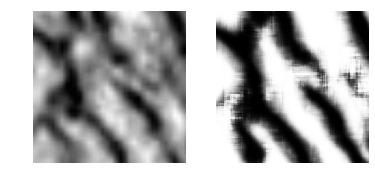

In [69]:
with open('mean_map.pic', 'rb') as f:
    mean_map = pickle.load(f)
golgi_resized = np.zeros((1, 572, 572, 1), dtype=np.float32)
golgi_resized[0][:,:,0] = aug.resize(golgi, (572, 572))
golgi_resized -= mean_map
pred_y_g = model.predict(weights_name, golgi_resized)
center_im = aug.crop(golgi_resized[0][:,:,0], 92, 92, 388, 388)
multi_plot_image([center_im, pred_y_g[0][:,:,0]])

In [ ]:
def predict_image(im, model, patch_shape):
    # convert to array
    patch_shape = np.array(patch_shape) if not isinstance(patch_shape, np.array) else patch_shape
    # compute patch number
    im_shape = np.array(im.shape)
    patch_num = im_shape / patch_shape
    assert (patch_num == np.round(patch_num)).all()
    # patch cordinate
    x, y = np.meshgrid()
    # compute padding shape
    pad_shape = np.round((patch_shape * 572 / 388 - patch_shape) / 2)
    im = np.pad(im, pad_shape, 'symmetric')
    patch_shape_w = patch_shape + pad_shape

376
(512, 512)
(632, 632)


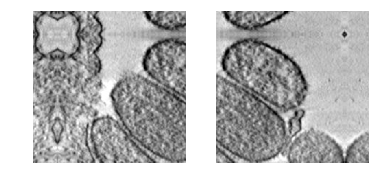

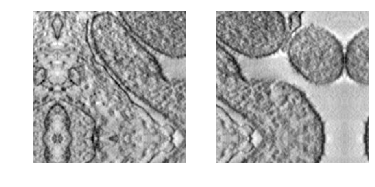

(4, 572, 572, 1)


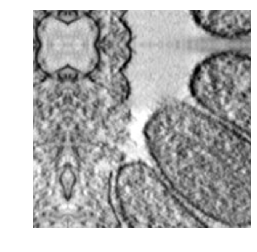

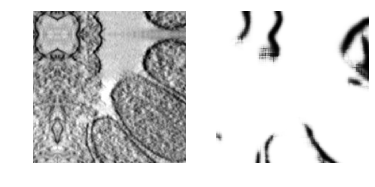

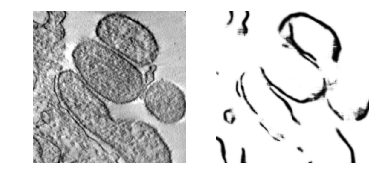

In [163]:
with Image.open('../data/membrane.tif') as im:
    im = np.array(im) / 255
im = aug.resize(im[0:300, 650:], (512, 512))
cs = 256
ps = np.int32((cs * 572 / 388 - cs) / 2)
im1 = np.pad(im, (ps, ps), 'symmetric')
s0 = cs + ps * 2
print(s0)

im_lt = aug.crop(im1, 0, 0, s0, s0)
im_lb = aug.crop(im1, 0, cs, s0, s0)
im_rt = aug.crop(im1, cs, 0, s0, s0)
im_rb = aug.crop(im1, cs, cs, s0, s0)
im_stack = [im_lt, im_lb, im_rt, im_rb]
im_stack = aug.augment_mask(im_stack, aug.resize, dst_size=(572, 572))
print(im.shape)
print(im1.shape)
multi_plot_image([im_lt, im_lb])
multi_plot_image([im_rt, im_rb])

ims = np.array(im_stack)
ims = np.reshape(ims, (4, 572, 572, 1))
print(ims.shape)
plot_image(ims[0][:,:,0])

# normalize
ims -= mean_map
y0 = model.predict(weights_name, ims)
y0 = np.squeeze(y0)
multi_plot_image([ims[0][:,:,0], y0[0]])
# resize

#merge
y_t0 = np.zeros((512, 512))
y_t0[0:cs, 0:cs] = aug.resize(y0[0], (cs, cs))
y_t0[0:cs, cs:] = aug.resize(y0[1], (cs, cs))
y_t0[cs:, 0:cs] = aug.resize(y0[2], (cs, cs))
y_t0[cs:, cs:] = aug.resize(y0[3], (cs, cs))

multi_plot_image([im, y_t0])
y_t0 = y_t0 > 0.5
#skio.imsave( "../data/test_mask_11.tif", np.uint8(255*y_t0))

In [143]:
golgi = np.zeros((260, 260))

72
(100, 100)
(122, 122)


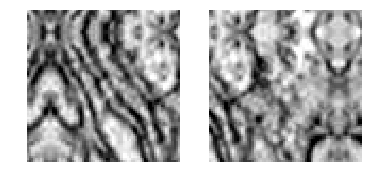

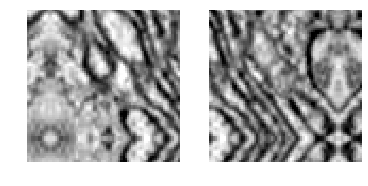

(4, 572, 572, 1)


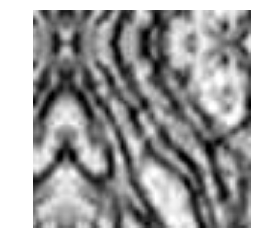

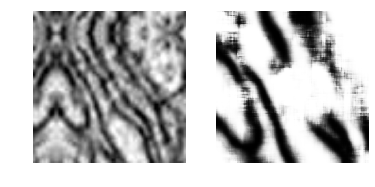

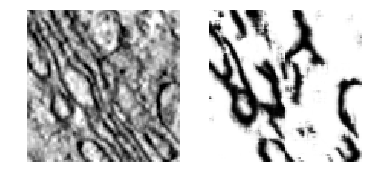

In [158]:
with Image.open('../data/golgi.tif') as im:
    im = np.array(im) / 255
im = im[80:180, 80:180]
cs = 50
ps = np.int32((cs * 572 / 388 - cs) / 2)
im1 = np.pad(im, (ps, ps), 'symmetric')
s0 = cs + ps * 2
print(s0)

im_lt = aug.crop(im1, 0, 0, s0, s0)
im_lb = aug.crop(im1, 0, cs, s0, s0)
im_rt = aug.crop(im1, cs, 0, s0, s0)
im_rb = aug.crop(im1, cs, cs, s0, s0)
im_stack = [im_lt, im_lb, im_rt, im_rb]
im_stack = aug.augment_mask(im_stack, aug.resize, dst_size=(572, 572))
print(im.shape)
print(im1.shape)
multi_plot_image([im_lt, im_lb])
multi_plot_image([im_rt, im_rb])

ims = np.array(im_stack)
ims = np.reshape(ims, (4, 572, 572, 1))
print(ims.shape)
plot_image(ims[0][:,:,0])

# normalize
ims -= mean_map
y0 = model.predict(weights_name, ims)
y0 = np.squeeze(y0)
multi_plot_image([ims[0][:,:,0], y0[0]])
# resize

#merge
y_t0 = np.zeros((100, 100))
y_t0[0:cs, 0:cs] = aug.resize(y0[0], (cs, cs))
y_t0[0:cs, cs:] = aug.resize(y0[1], (cs, cs))
y_t0[cs:, 0:cs] = aug.resize(y0[2], (cs, cs))
y_t0[cs:, cs:] = aug.resize(y0[3], (cs, cs))

multi_plot_image([im, y_t0])

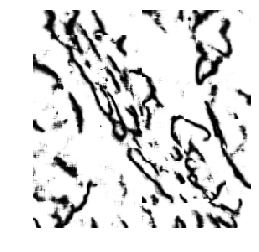

In [159]:
golgi[80:180, 80:180] = y_t0
plot_image(golgi)

In [160]:
a = golgi > 0.7
skio.imsave( "../data/golgi_mask.tif", np.uint8(255*a))